In [1]:
!pip install transformers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, r2_score
import torch
import os
from transformers import BertTokenizer,BertForSequenceClassification, AdamW
from tqdm.notebook import tqdm
from scipy.special import softmax
#Train on GPU if available (go to 'Edit/Notebook Settings' in Colab to enable)
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [0]:
def train_data(directory):
    df = pd.read_csv(filename)
    df['Answer1'] = df['AnswerCount']>=1
    df['Answer2'] = df['AnswerCount']>=2
    df['AnswerAcc'] = ~df['AcceptedAnswerId'].isna()
    mask = (df['ClosedDate'].isna())
    X,y= df[mask]['Title'].values,df[mask][['Answer1','Answer2','AnswerAcc']].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_per_step, random_state=42)
    train_gen = enumerate(zip(X_train,y_train))
    for step in range(num_steps):
      for i,(X_i,y_i) in tqdm(enumerate(zip(X_test,y_test)),total=test_per_step):
        i -= step*test_per_step
        yield 'test',i,X_i,y_i
      for i,(X_i,y_i) in tqdm(train_gen,total=train_per_step):
        i -= step*train_per_step
        if i>=train_per_step:
          break
        yield 'train',i,X_i,y_i
      yield 'checkpoint',step,X_i,y_i

In [0]:
def cross_entropy(true_out,raw_out):
  prob = torch.exp(raw_out)/(1+torch.exp(raw_out))
  if true_out:
    return -torch.log(prob)
  else:
    return -torch.log(1-prob)
    
def least_squares(true_out,raw_out):
  return 0.5*(true_out-raw_out)**2

def multi_loss(hidden_out,y_actual):
  out = []
  loss_functions = 3*[cross_entropy]
  for raw_out,true_out,loss in zip(hidden_out,y_actual,loss_functions):
    out.append(loss(true_out,raw_out))
  return out



In [6]:
#Fine-tuning BERT to predict whether a question will be answered, based on the title.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-7)
#Evaluation mode disables dropout layers, which aren't needed when we only train for a single epoch.
model.eval()

filename = '/content/drive/My Drive/Colab Notebooks/BERT_6-10/so_4.csv'
num_steps = 20
train_per_step = 10000
test_per_step = 10000

test_results = []
#Training loop
for mode,i,X_i,y_i in train_data(filename):
  if mode=='train':
    #Encode the titles (the prefix 'summarize: ' tells it to summarize)
    X_i = tokenizer.encode(X_i, return_tensors="pt").to(device)
    #Foward pass through the network
    hidden_out = model(X_i)[0][0]
    losses = multi_loss(hidden_out,y_i)
    #Backward pass to compute the gradients
    sum(losses).backward()
    #losses_over_time.append([l.detach().cpu().numpy() for l in losses])
    #Update the parameters with gradient descent
    optimizer.step()
    optimizer.zero_grad()
    model.zero_grad()
  elif mode=='test':
    with torch.no_grad():
        #Encode the titles (the prefix 'summarize: ' tells it to summarize)
        X_i = tokenizer.encode(X_i, return_tensors="pt").to(device)
        #Foward pass through the network
        hidden_out = model(X_i)[0][0]
        test_results.append(hidden_out.detach().cpu().numpy())
  elif mode=='checkpoint':
    #Save the model
    print('Saving model...')
    print()
    checkpoint_directory = f'bert437/{i}'
    if not os.path.exists(checkpoint_directory):
        os.makedirs(checkpoint_directory)
    model.save_pretrained(checkpoint_directory)

KeyboardInterrupt: ignored

In [0]:
tr = np.reshape(np.array(test_results),[14,-1,3])

In [8]:
df = pd.read_csv(filename)
df['Answer1'] = df['AnswerCount']>=1
df['Answer2'] = df['AnswerCount']>=2
df['AnswerAcc'] = ~df['AcceptedAnswerId'].isna()
mask = (df['ClosedDate'].isna())
X,y= df[mask]['Title'].values,df[mask][['Answer1','Answer2','AnswerAcc']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_per_step, random_state=42)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
def get_roc_auc(true_out,raw_out):
  prob = np.exp(raw_out)/(1+np.exp(raw_out))
  return roc_auc_score(true_out,prob)
    
def get_rsq(true_out,raw_out):
  return r2_score(true_out,raw_out)

def multi_score(y_actual,hidden_out):
  out = []
  score_functions = 3*[get_roc_auc]+[get_rsq]
  for raw_out,true_out,scorer in zip(np.transpose(hidden_out),np.transpose(y_actual),score_functions):
    out.append(scorer(true_out,raw_out))
  return out

#multi_score(y_test.astype(int),tr[-1])
scores = [multi_score(y_test.astype(int),tr_step) for tr_step in tr]


In [11]:
np.array(test_results).shape

(140000, 3)

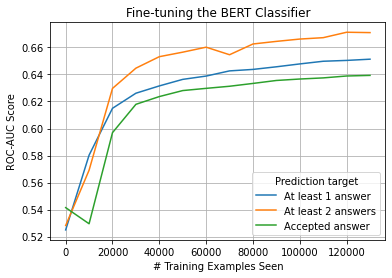

In [37]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0,130000,14),scores)
plt.xlabel('# Training Examples Seen')
plt.ylabel('ROC-AUC Score')
plt.legend(['At least 1 answer','At least 2 answers','Accepted answer'],title='Prediction target')
#plt.gca().tick_params(right=True,labelright=True,left=False,labelleft=False)
#plt.gca().yaxis.set_label_position("right")
#plt.gca().yaxis.tick_right()
plt.grid()
plt.title('Fine-tuning the BERT Classifier')
plt.savefig('bert_roc_auc.png',dpi=500)

In [0]:
np.save('tr.npy',tr)

In [38]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
checkpoint_directory = '/content/drive/My Drive/Colab Notebooks/BERT_6-10/BERT_6-10'
model.save_pretrained(checkpoint_directory)